<a href="https://colab.research.google.com/github/andy-nguyen-21/BrazilianE-Commerce/blob/main/E_commerce_data_analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
My name is [Andy Nguyen](https://www.linkedin.com/in/dung-nguyen-012/).
This is a project I am practicing my data analytics skills using a Brazilian ecommerce public dataset of orders made at [Olist Store](http://www.olist.com/).

---
Data source: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

# Database Schema Diagram
![Alt text](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2473556%2F23a7d4d8cd99e36e32e57303eb804fff%2Fdb-schema.png?generation=1714391550829633&alt=media)
Source: [Terenci Claramunt](https://www.kaggle.com/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/data)

In [1]:
import kagglehub
import os
import sqlite3
import pandas as pd

# This downloads the dataset and returns the path to the downloaded folder
print("Downloading raw e-commerce data...")
download_path = kagglehub.dataset_download('olistbr/brazilian-ecommerce')
print(f"Download complete. Files are in: {download_path}")

# Create a new SQLite database
db_path = 'brazilian_ecommerce.sqlite'
db_connection = sqlite3.connect(db_path)
print(f"Created new database: {db_path}")

# List of CSV files and their corresponding table names
csv_files = {
    'olist_customers_dataset.csv': 'customers',
    'olist_geolocation_dataset.csv': 'geolocation',
    'olist_orders_dataset.csv': 'orders',
    'olist_order_items_dataset.csv': 'order_items',
    'olist_order_payments_dataset.csv': 'order_payments',
    'olist_order_reviews_dataset.csv': 'order_reviews',
    'olist_products_dataset.csv': 'products',
    'olist_sellers_dataset.csv': 'sellers',
    'product_category_name_translation.csv': 'product_category_name_translation'
}

# Loop through each CSV file and import it into a new table
for csv_file, table_name in csv_files.items():
    file_path = os.path.join(download_path, csv_file)
    if os.path.exists(file_path):
        print(f"Importing {csv_file} into table {table_name}...")
        df = pd.read_csv(file_path)
        df.to_sql(table_name, db_connection, if_exists='replace', index=False)
        print(f"Import of {table_name} complete.")
    else:
        print(f"Warning: {csv_file} not found at {file_path}. Skipping.")

print("All data imported")

Download complete. Files are in: /kaggle/input/brazilian-ecommerce
Created new database: brazilian_ecommerce.sqlite
Importing olist_customers_dataset.csv into table customers...
Import of customers complete.
Importing olist_geolocation_dataset.csv into table geolocation...
Import of geolocation complete.
Importing olist_orders_dataset.csv into table orders...
Import of orders complete.
Importing olist_order_items_dataset.csv into table order_items...
Import of order_items complete.
Importing olist_order_payments_dataset.csv into table order_payments...
Import of order_payments complete.
Importing olist_order_reviews_dataset.csv into table order_reviews...
Import of order_reviews complete.
Importing olist_products_dataset.csv into table products...
Import of products complete.
Importing olist_sellers_dataset.csv into table sellers...
Import of sellers complete.
Importing product_category_name_translation.csv into table product_category_name_translation...
Import of product_category_name

# Connect To The Database
The sqlite3 library allows us to query the database using python without a dedicated server running on the background.

Create `view_table()`: easily view a limited number of rows from any SQLite table as a pandas DataFrame.

In [2]:
import pandas as pd

def view_table(table, row_limit):
  query = f"""
    SELECT *
    FROM {table}
    LIMIT {row_limit}
  """
  return pd.read_sql_query(query, db_connection)

# Orders Volume Trend


## Order Growth Over Time

In [3]:
print("The first 4 columns of 'orders' table:")
view_table('orders', 5).iloc[:, :4]

The first 4 columns of 'orders' table:


,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [4]:
print("The remaining columns of 'orders' table:")
view_table('orders', 5).iloc[:, 4:]

The remaining columns of 'orders' table:


,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
print("""Calculate the total orders per day:
Note: I filter out orders before 2017-01, and after 2018-08 due to suspected missing data """)
oders_per_day_query = """
SELECT
  strftime('%Y-%m-%d', order_purchase_timestamp) AS order_date,
  COUNT(*) AS order_count,
  strftime('%Y-%m', order_purchase_timestamp) AS year_month
FROM
  orders
WHERE
  order_status = 'delivered'
  AND order_purchase_timestamp >= '2017-01-01' -- Filter out orders before 2017-01,
  AND order_purchase_timestamp < '2018-08-01'  -- and after 2018-08 due to suspected missing data
GROUP BY
  order_date
ORDER BY
  order_date;
"""
orders_per_day = pd.read_sql_query(oders_per_day_query, db_connection)
orders_per_day.head(5)

Calculate the total orders per day:
Note: I filter out orders before 2017-01, and after 2018-08 due to suspected missing data 


,order_date,order_count,year_month
0,2017-01-05,32,2017-01
1,2017-01-06,4,2017-01
2,2017-01-07,4,2017-01
3,2017-01-08,4,2017-01
4,2017-01-09,5,2017-01


Generating plot:


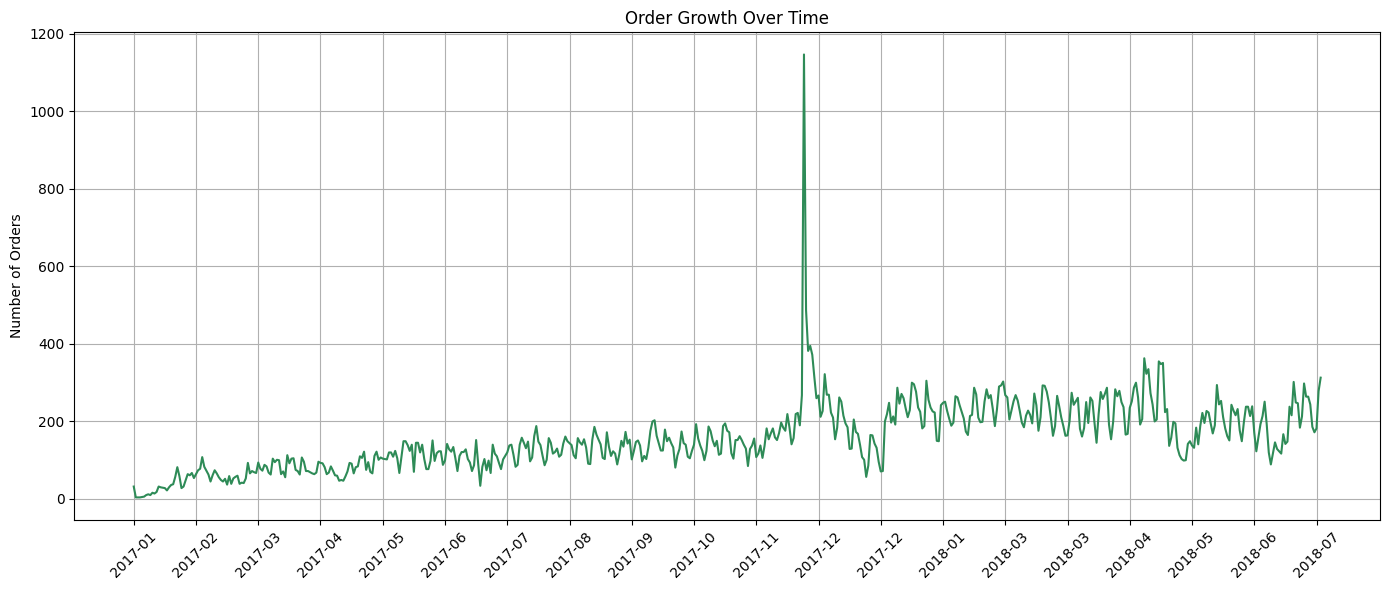

In [6]:
import matplotlib.pyplot as plt
print("Generating plot:")

plt.figure(figsize=(14, 6)) # Use plt.figure to set the figure size
plt.plot(orders_per_day.index, orders_per_day['order_count'], color='seagreen') # Plot against the index
plt.ylabel('Number of Orders')
plt.title('Order Growth Over Time')

# Set the x-axis ticks and labels
plt.xticks(orders_per_day.index[::30], orders_per_day['year_month'][::30], rotation=45) # Use year_month for labels, show every 30th tick

plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

- **Overall Trend:**
General upward trend in the number of orders per day from beginning 2017 through most of 2018. This suggests the e-commerce platform was growing during this period.
- **Seasonality/Peaks:**
There are noticeable peaks in the number of order. This could be due to various factors like holiday shopping seasons such as Black Friday or Christmas  or specific marketing campaigns.
- **Variability:** There is daily variability in the number of orders, which is expected. Some days have significantly more orders than others.

## Daily and Hourly Order Trends

In [7]:
print("""Determine weekday and hour of day of the order:""")
oders_by_weekday_and_hour_query = """
SELECT
  order_purchase_timestamp,
  strftime('%w', order_purchase_timestamp) AS week_day,
  strftime('%H', order_purchase_timestamp) AS hour_of_day
FROM
  orders
WHERE
  order_status = 'delivered'
  AND order_purchase_timestamp >= '2017-01-01' -- Filter out orders before 2017-01,
  AND order_purchase_timestamp < '2018-08-01'  -- and after 2018-08 due to suspected missing data
ORDER BY
  order_purchase_timestamp;
"""
oders_by_weekday_and_hour = pd.read_sql_query(oders_by_weekday_and_hour_query, db_connection)
oders_by_weekday_and_hour.head(5)

Determine weekday and hour of day of the order:


,order_purchase_timestamp,week_day,hour_of_day
0,2017-01-05 11:56:06,4,11
1,2017-01-05 12:01:20,4,12
2,2017-01-05 12:06:36,4,12
3,2017-01-05 12:09:08,4,12
4,2017-01-05 12:11:23,4,12


In [8]:
import seaborn as sns

print("Create heatmap dataframe")
heat_map_query = """
  SELECT
    strftime('%w', order_purchase_timestamp) AS week_day,
    strftime('%H', order_purchase_timestamp) AS hour_of_day,
    COUNT(*) AS order_count
  FROM
    orders
  GROUP BY
    week_day, hour_of_day
  ORDER BY
    week_day, hour_of_day;
"""

heatmap = pd.read_sql_query(heat_map_query, db_connection)

# Map day numbers to names for better readability
name_week_day = {
    '0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday',
    '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
}

heatmap['week_day'] = heatmap['week_day'].map(name_week_day)

# Pivot the DataFrame to create a matrix
pivot_heatmap = heatmap.pivot_table(index='week_day', columns='hour_of_day', values='order_count', fill_value=0)
display(pivot_heatmap)

Create heatmap dataframe


hour_of_day,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
week_day,,,,,,,,,,,,,,,,,,,,,
Friday,426.0,216.0,72.0,49.0,40.0,36.0,97.0,206.0,493.0,768.0,...,961.0,979.0,974.0,817.0,723.0,784.0,738.0,726.0,702.0,512.0
Monday,328.0,134.0,66.0,36.0,21.0,22.0,69.0,160.0,479.0,783.0,...,1096.0,1079.0,1094.0,992.0,928.0,945.0,1027.0,1118.0,991.0,717.0
Saturday,315.0,175.0,67.0,43.0,25.0,24.0,53.0,106.0,249.0,434.0,...,677.0,722.0,697.0,701.0,710.0,756.0,730.0,654.0,550.0,429.0
Sunday,267.0,141.0,69.0,44.0,27.0,27.0,34.0,105.0,205.0,349.0,...,684.0,716.0,712.0,797.0,895.0,899.0,967.0,889.0,873.0,607.0
Thursday,355.0,167.0,75.0,39.0,31.0,28.0,85.0,220.0,502.0,758.0,...,977.0,928.0,1077.0,909.0,784.0,826.0,839.0,840.0,857.0,551.0
Tuesday,306.0,158.0,80.0,28.0,29.0,24.0,71.0,223.0,522.0,864.0,...,1124.0,1047.0,1081.0,967.0,877.0,924.0,988.0,1027.0,965.0,692.0
Wednesday,397.0,179.0,81.0,33.0,33.0,27.0,93.0,211.0,517.0,829.0,...,1050.0,983.0,1040.0,967.0,852.0,848.0,904.0,963.0,878.0,615.0


Generating heatmap:


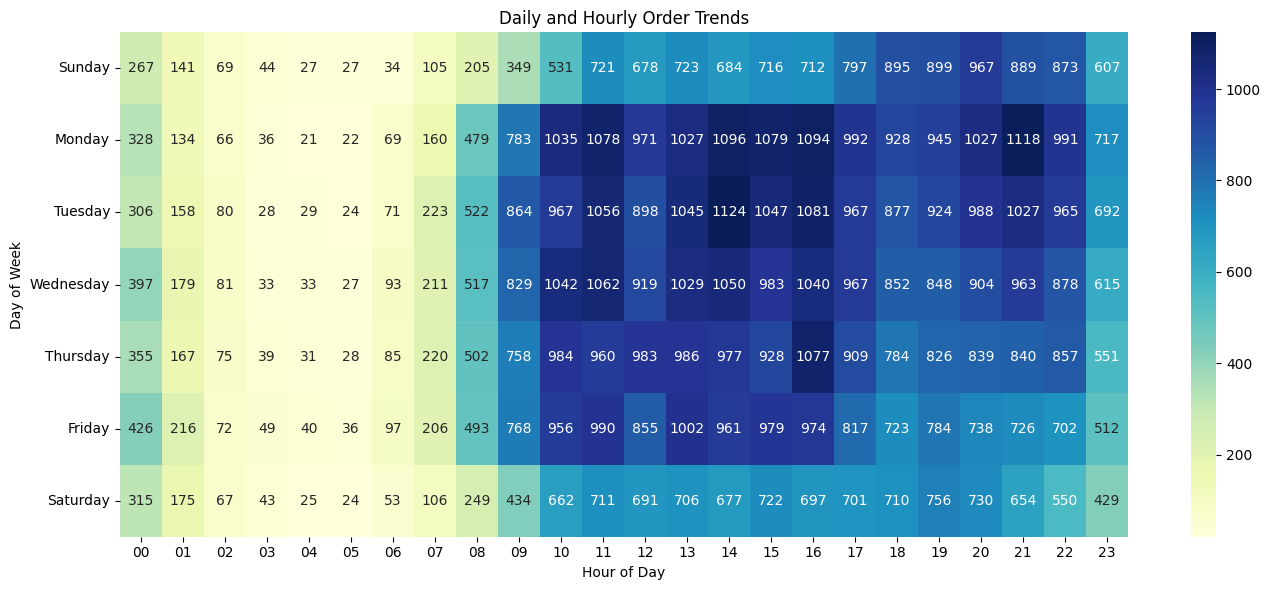

In [9]:
print("Generating heatmap:")
# Reorder the days of the week
reorder_week_day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
pivot_heatmap = pivot_heatmap.reindex(reorder_week_day)

# Create the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_heatmap, cmap='YlGnBu', annot=True, fmt='g')

plt.title('Daily and Hourly Order Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()

The heatmap illustrates the distribution of orders throughout the week and across different hours of the day.
* **Overall Trend:**
1.  A prominent trend is the concentration of orders during
weekday working hours (9AM-5PM). Following a slight dip, order volume surges again in the evening, reaching another peak between 7 PM and midnight.
2.  Weekends have significantly lower order volumn which could indicate a shift to offline shopping or other activities.
3.  The lowest activity is consistently during sleep hours, with minimal orders from 3AM to 6 AM.
* **Variability:**
1. An unsual spike occurs at midnight, potentially driven by 24-hour sales or late-night promotions.
2. Orders on Thursday and Friday nights are approximately 20% lower than the average for other weekdays during the same hours.



## States Driven the Most Orders

In [10]:
# Preview Orders table:
view_table('orders', 5).iloc[:, :4]

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [11]:
# Preview Customers table:
view_table('customers', 5).iloc[:, :5]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
# Find TOP 10 States of Order Volumn:
top_10_state_querry = """
  SELECT *
  FROM
    (
    SELECT
      customer_state,
      COUNT(*) AS order_count
    FROM
      orders
      JOIN customers USING (customer_id)
    GROUP BY
      customer_state
    ORDER BY
      order_count DESC
    LIMIT 10
    )
  ORDER BY
    order_count
"""
top_10_state = pd.read_sql_query(top_10_state_querry, db_connection)

# Transfer State abbreviations to State names for better readability:

brazilian_state_names = {
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    'MG': 'Minas Gerais',
    'RS': 'Rio Grande do Sul',
    'PR': 'Paraná',
    'SC': 'Santa Catarina',
    'BA': 'Bahia',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'PE': 'Pernambuco',
    'CE': 'Ceará',
    'PA': 'Pará',
    'MT': 'Mato Grosso',
    'MA': 'Maranhão',
    'MS': 'Mato Grosso do Sul',
    'PB': 'Paraíba',
    'PI': 'Piauí',
    'RN': 'Rio Grande do Norte',
    'AL': 'Alagoas',
    'SE': 'Sergipe',
    'TO': 'Tocantins',
    'RO': 'Rondônia',
    'AM': 'Amazonas',
    'AC': 'Acre',
    'AP': 'Amapá',
    'RR': 'Roraima'
}

top_10_state['customer_state'] = top_10_state['customer_state'].map(brazilian_state_names)
print("TOP 10 States by Order Volumn:")
top_10_state

TOP 10 States by Order Volumn:


,customer_state,order_count
0,Goiás,2020
1,Espírito Santo,2033
2,Distrito Federal,2140
3,Bahia,3380
4,Santa Catarina,3637
5,Paraná,5045
6,Rio Grande do Sul,5466
7,Minas Gerais,11635
8,Rio de Janeiro,12852
9,São Paulo,41746


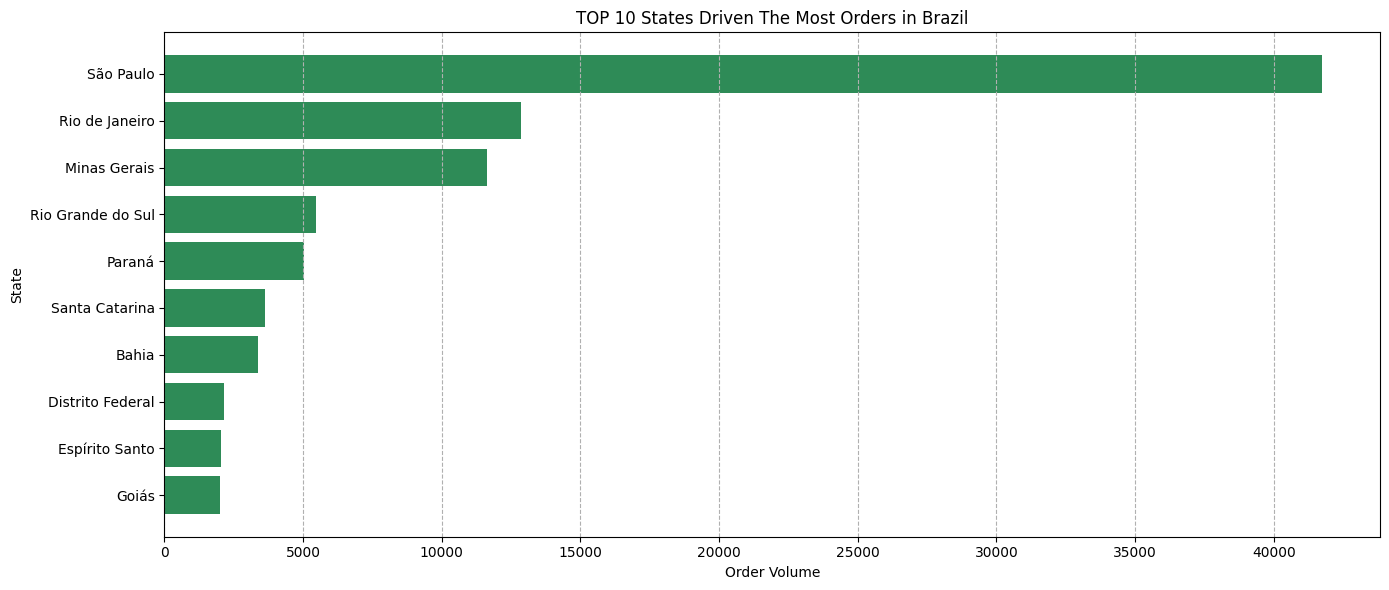

In [13]:
# Create bar chart for top 10 states by order volumn
plt.figure(figsize=(14, 6))
plt.barh(top_10_state['customer_state'], top_10_state['order_count'], color='seagreen')
plt.xlabel('Order Volume')
plt.ylabel('State')
plt.title('TOP 10 States Driven The Most Orders in Brazil')

plt.tight_layout()
plt.grid(axis='x', linestyle='--')
plt.show()

This graph depicts Top 10 state which have the most order volume.

*   **Key Observations and Potential Insights:**


1.   The top 3 states, São Paulo, Rio de Janeiro, and Minas Gerais, exhibit significantly higher order volumes compared to the rest (Geolocation data backup required. I just google these cities are really the biggest pretending I am a knowledgable Brazillian citizen).
2.   The substantial order volume in São Paulo, in particular, suggests there may be specific factors contributing to its success. Further exploration into demographics, local infrastructure, or targeted marketing campaigns in São Paulo could reveal strategies applicable to boosting order volume in other states and potentially creating similar "success stories."





# Order Items Pricing

In [14]:
view_table('order_items', 5).iloc[:, :3]

,order_id,order_item_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089


In [15]:
view_table('order_items', 5).iloc[:, 3:]

,seller_id,shipping_limit_date,price,freight_value
0,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
product_and_freight_cost_query = """
  SELECT
    order_id,
    SUM(price) AS total_price,
    SUM(freight_value) AS total_freight,
    COUNT(*) AS item_count
  FROM
    order_items
  GROUP BY
    order_id

"""

product_and_freight_cost = pd.read_sql_query(product_and_freight_cost_query, db_connection)
product_and_freight_cost.head(5)

,order_id,total_price,total_freight,item_count
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1


## Product Amount per Order  
Let's see how many items customers usually putting on their order:


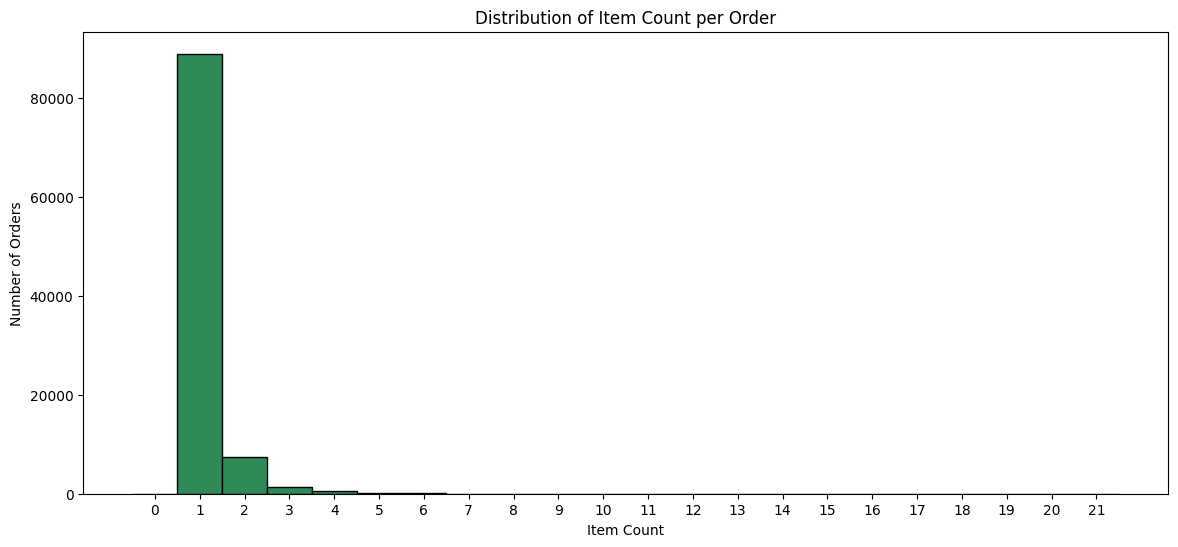

In [17]:
# Generating histogram plot on item_count per order_id
plt.figure(figsize=(14, 6))

# Set bins to be centered around integers
max_item_count = int(product_and_freight_cost['item_count'].max())
bins = range(0, max_item_count + 2) # Create bins that are centered around integers

plt.hist(product_and_freight_cost['item_count'], bins=bins, color='seagreen', edgecolor='black', align='left') # Use align='left' or 'mid' depending on desired centering

plt.xlabel('Item Count')
plt.ylabel('Number of Orders')
plt.title('Distribution of Item Count per Order')


# Set x-axis ticks to be integers and centered
plt.xticks(range(0, max_item_count + 1))

plt.show()

**Observations and Potential Insights:**  
*   The graph reveals a strong preference for single-items purchases. A significant drop-off in order volume occurs with multi-item orders, highlighting that customers are less likely to buy multiple products in a single transaction.
*   There are a small number of orders with a considerably higher item count, suggesting occasional bulk purchases or specific product types that are bought in larger quantities.
*   Understanding this preference for single-item orders is crucial for optimizing inventory management, shipping costs, and marketing strategies aimed at increasing the average order value.



## Order Volume Relation with Order Value and Freight Cost

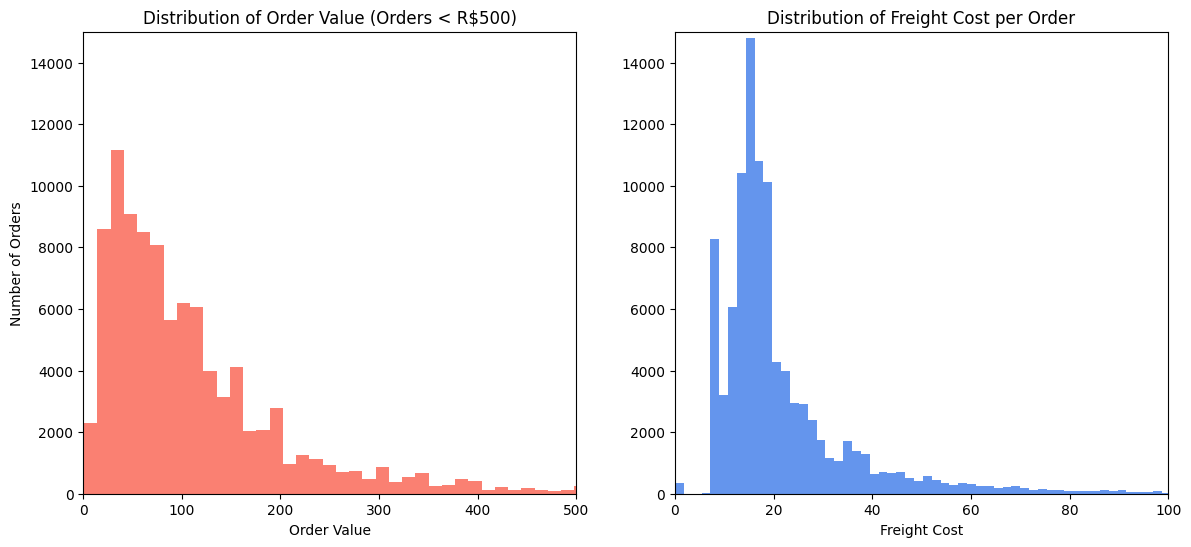

In [18]:
plt.figure(figsize=(14, 6))

# Generating product pricing range by order plot
plt.subplot(1, 2, 1)
plt.hist(product_and_freight_cost['total_price'], bins=1000, color='salmon') # Increased bins for better detail in the limited range

plt.xlabel('Order Value')
plt.ylabel('Number of Orders')
plt.title('Distribution of Order Value (Orders < R$500)') # Updated title

plt.xlim(0, 500) # Set the x-axis limit to 500
plt.ylim(0, 15000) # Set the y-axis limit to 15000

#Generating freight fee by order plot
plt.subplot(1, 2, 2)
plt.hist(product_and_freight_cost['total_freight'], bins=1000, color='cornflowerblue') # Increased bins for better detail in the limited range

plt.xlabel('Freight Cost')
plt.title('Distribution of Freight Cost per Order')

plt.xlim(0, 100) # Set the x-axis limit to 100
plt.ylim(0, 15000) # Set the y-axis limit to 15000

plt.show()

**Observations and Potential Insights:**  
*   The highest volume of orders occurs for values around 80 Real, with the majority of transactions falling below 200 Real. The distribution is heavily skewed towards lower order values, indicating that most customers purchase items with a relatively low total price.
*   Similarly, freight costs are substantially concentrated between 10  Real and 20 Real, suggesting a common range for shipping fees. The number of orders decreases significantly for higher freight costs. This distribution could be influenced by factors such as shipping distance and product weight.
*   Understanding these pricing distributions is important for pricing strategies, shipping options, and potentially identifying opportunities to encourage higher-value orders or optimize freight costs.


# Revenue Breakdown by Category  
This analysis explores customer preferences across product categories by examining both sales value and transaction volume.

In [19]:
view_table('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [20]:
# JOIN 3 tables: order_items, product_category_name_translation, products
product_category_in_order_query = ("""
    SELECT
      order_id,
      order_item_id,
      product_category_name_english,
      price
    FROM
      order_items
      JOIN products USING (product_id)
      JOIN product_category_name_translation USING (product_category_name)
    ORDER BY
      order_id
""")
product_category_in_order = pd.read_sql_query(product_category_in_order_query, db_connection)
product_category_in_order.head(5)

,order_id,order_item_id,product_category_name_english,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,pet_shop,239.90
2,000229ec398224ef6ca0657da4fc703e,1,furniture_decor,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,perfumery,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,garden_tools,199.90


## Sales Value

In [21]:
# Prepare datatable:
category_value_tree_map_query = f"""
  SELECT
    product_category_name_english,
    SUM(price) AS total_value
  FROM
    ({product_category_in_order_query})
  GROUP BY
    product_category_name_english
"""
category_value_tree_map = pd.read_sql_query(category_value_tree_map_query, db_connection)
category_value_tree_map.head(5)

# Create treemap:
import plotly.express as px

# Label improving: Capitalize the first letter and remove under score
category_value_tree_map['product_category_name_english_cleaned'] = category_value_tree_map['product_category_name_english'].str.replace('_', ' ').str.title()

# Create treemap for category sale value
fig = px.treemap(
    category_value_tree_map,
    path=['product_category_name_english_cleaned'],
    values='total_value',
    title='Sales Breakdown by Category',
    color='total_value', # Color the treemap based on total_value
    hover_data=['total_value'], # Add total_value to hover information
    color_continuous_scale='Viridis' # Use a different color scale
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # Adjust layout margins

fig.show()

## Items Volume

In [22]:
# Prepare datatable:
category_order_count_tree_map_query = f"""
  SELECT
    product_category_name_english,
    COUNT(*) AS item_count
  FROM
    ({product_category_in_order_query})
  GROUP BY
    product_category_name_english
"""
category_order_count_tree_map = pd.read_sql_query(category_order_count_tree_map_query, db_connection)
category_order_count_tree_map.head(5)

# Label improving: Capitalize the first letter and remove under score
category_order_count_tree_map['product_category_name_english_cleaned'] = category_value_tree_map['product_category_name_english'].str.replace('_', ' ').str.title()

# Create treemap for category item count
fig = px.treemap(
    category_order_count_tree_map,
    path=['product_category_name_english_cleaned'],
    values='item_count',
    title='Item Count Breakdown by Category',
    color='item_count', # Color the treemap based on item_count
    hover_data=['item_count'], # Add item_count to hover information
    color_continuous_scale='Viridis' # Use a different color scale
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # Adjust layout margins

fig.show()


## Relation

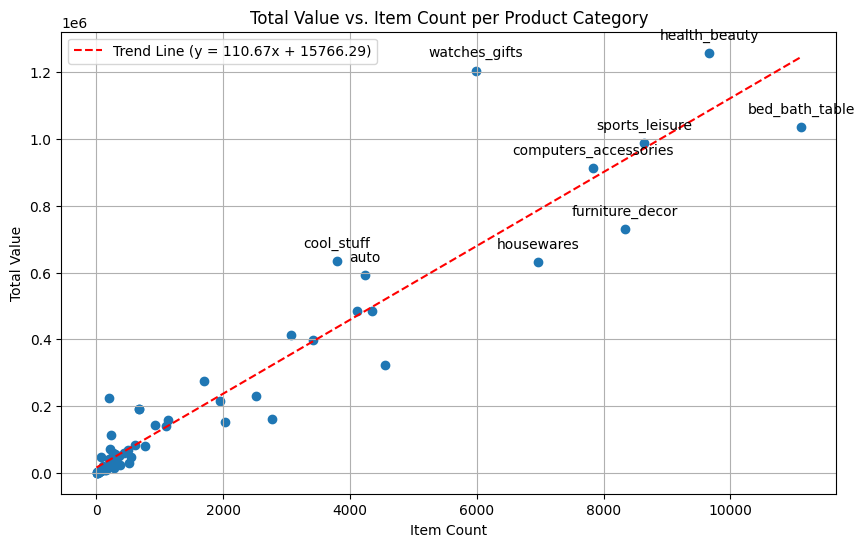

In [23]:
# JOIN 2 treemap tables
joined_category_tables_query = f"""
    SELECT
      *
    FROM
      ({category_value_tree_map_query})
      JOIN ({category_order_count_tree_map_query}) USING (product_category_name_english)
"""
joined_category_tables = pd.read_sql_query(joined_category_tables_query, db_connection)
joined_category_tables.head(5)

# Create linear plot between category value and item count

plt.figure(figsize=(10, 6)) # Increase figure size for better readability
plt.scatter(joined_category_tables.item_count, joined_category_tables.total_value)
plt.xlabel('Item Count')
plt.ylabel('Total Value')
plt.title('Total Value vs. Item Count per Product Category') # Add a title
plt.grid(True) # Add a grid for easier reading of values

# Add a linear regression line (trend line)
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape data for linear regression
X = joined_category_tables['item_count'].values.reshape(-1, 1)
y = joined_category_tables['total_value'].values.reshape(-1, 1)

# Fit the linear model
model = LinearRegression()
model.fit(X, y)

# Predict values for the trend line
trend_X = np.array([X.min(), X.max()]).reshape(-1, 1)
trend_y = model.predict(trend_X)

plt.plot(trend_X, trend_y, color='red', linestyle='--', label=f'Trend Line (y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f})')
plt.legend()

# Label categories with item_count > 5k or total_value > 0.5M
for i, row in joined_category_tables.iterrows():
    if row['item_count'] > 5000 or row['total_value'] > 500000:
        plt.annotate(row['product_category_name_english'], (row['item_count'], row['total_value']), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

**Observation:**
* The treemaps effectively highlight the dominance of a few product categories in terms of both sales value and item count (like 'health_beauty', 'bed_bath_table', 'sports_leisure', 'watches_gifts', 'computers_accessories', 'furniture_decor', 'housewares', and 'auto').
* The scatter plot confirms the generally linear relationship between item count and total value across categories, indicating that categories with more items sold tend to generate higher revenue.

**Potential Analysis**
* Deep dive into Top categories: best-sellings, average order value by category.
* Price distribution of products within high-performing and low-performing categories.
* Temporal Trends within Categories such as seasonal trends or feight cost or growth patterns.